In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import torch

# (0) - Toy Data Generation

In [2]:
from spacetime.spacetime import SpaceTime, NodeData
from spacetime.simulate import Simulator
from spacetime.utils import Parameters
from spacetime.sampler import PDFVisualizer

###### Set the number of nodes and the dimension of the data

In [3]:
n_nodes, d_data = 6, 1

###### Define the parameters of the toy data set

In [4]:
sim_params = Parameters(graph = {'degree':3, 'graph_type':'causal-chain2', 'w_range':(0.5, 2.0), 
                                 'force_positive':False, 'seed':6},
                        data = {'n_samples':8000, 'linear_type':'nonlinear_2', 'sem_type':'linear-gauss', 
                                'noise_scale':1.0, 'x_dims':d_data, 'seed':0})

###### Generate a random graph for the ground-truth

simulating an ordered 3-degree causal-chain2 dag with range (0.5, 2.0) (seed 6)


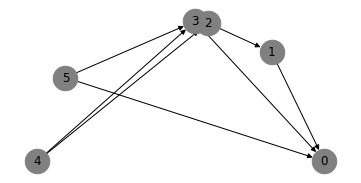

In [5]:
_split=1
node_list = list(range(n_nodes))
node_dict = {i:list(range(_split*i, _split*(i+1))) for i in range(n_nodes//_split)}

st_truth = SpaceTime(Simulator.ordered(node_dict, **sim_params.graph))
st_truth.draw_graph(backscore=False)

###### Isolate specific graph nodes (the 0-1-2 chain)  and generate a graph with mutilated node 2

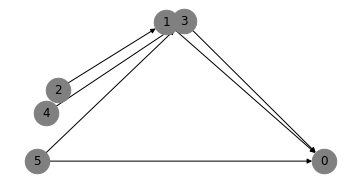

In [6]:
chain = list(reversed(torch.argsort(st_truth.time_scores(backscore=False)))[:3].tolist())
latent = [node for node in range(n_nodes) if node not in chain]
observe, mediate, mutilate = chain

st_truth_mutil = SpaceTime(st_truth.mutilate(mutilate))
st_truth_mutil.draw_graph()

###### Generate un-mutilated training data set from the structural equation model defined in the parameters

In [7]:
X = NodeData(Simulator.sem(st_truth.A.numpy(), **sim_params.data), sigma=6, bin_width=0.5)

simulating 8000 samples from a linear-gauss sem with nonlinear_2 causal effects


###### Generate the ground-truth mutilated data set and double the variance (4$\sigma$) in the data for the mutilated node 2

In [8]:
f_dict = {2:(sim_params.data['linear_type'], sim_params.data['sem_type'], 4.0)}
X_mutil = NodeData(Simulator.sem(st_truth_mutil.A.numpy(), **sim_params.data, 
                                 f_dict=f_dict, mutil=[mutilate]), bins=X.edges())

simulating 8000 samples from a linear-gauss sem with nonlinear_2 causal effects


###### Compare the conditional probability distributions between the mutilated and unmutilated data

In [9]:
from spacetime.utils import  plot_conditionals, plot_joints, plot_marginals

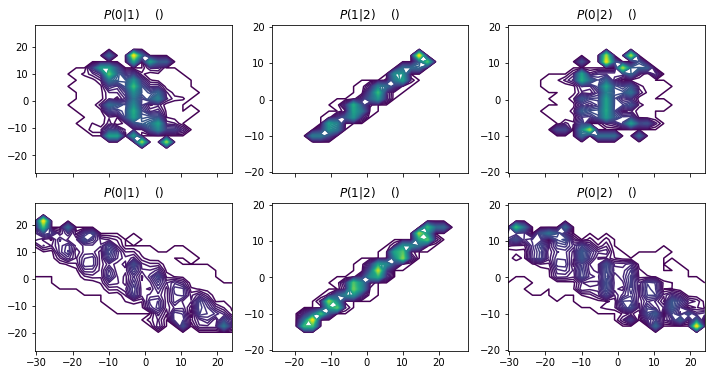

In [10]:
col_plot_dict = {0:(observe, mediate), 1:(mediate, mutilate), 2:(observe, mutilate)}

pX = PDFVisualizer(st_truth, X, observables=(0,1,2,3))
pX_mutil = PDFVisualizer(st_truth_mutil, X_mutil, observables=(0,1,2,3))

plot_conditionals(col_plot_dict, [pX, pX_mutil], ['']*2)

# (1) - DAG Learning

In [11]:
from spacetime.models import DAGGNN, DAGGAE
from spacetime.losses import ELBOLoss, InteractionLoss
from spacetime.optimizers import Coefficients, OptimModule
from spacetime.trainers import Validator, DAGTrainer
from spacetime.utils import plot_trials, plot_graphs

###### Define the parameters for the DAG-learning model

In [12]:
graph_params = Parameters(model = {'n_in':d_data, 'n_hid':64, 'n_out':d_data, 'dropout':0.0, 'gain':1.0},
                          train = {'batch_size':100, 'epochs':5},
                          opts = {'lr_init':1e-3, 'warmups':0, 'h_tol':1e-9, 'max_iters':30},
                          coeffs = {'l_init':1e-2, 'c_init':1.0, 'tau_init':1e-9, 'tr_init':100.},
                          ctrls = {'gamma':0.25/(1), 'eta':10.0/(1)})

###### Run three trials of the GAE algorithm

In [13]:
dagtrainer = DAGTrainer(n_nodes, X, graph_params, true_spacetime = st_truth)

for idx in range(3):
    dagtrainer.train(model=DAGGAE(n_nodes, graph_params), print_every=5)

***Iteration: 0, Best Epoch: 0/5
   elbo: 10^2.296 || kld: 10^2.289 || nll: 10^0.499 || lr: 10^-3.000
   h: 10^-3.091 || l1: 10^0.292 || l: 10^-2.000 || c: 10^0.000
   shd: 7.000 || tpr: 0.500 || fpr: 0.571 || err: 4.429
***Iteration: 5, Best Epoch: 4/5
   elbo: 10^2.281 || kld: 10^2.274 || nll: 10^0.466 || lr: 10^-3.602
   h: 10^-3.015 || l1: 10^0.298 || l: 10^-1.966 || c: 10^4.000
   shd: 7.000 || tpr: 0.500 || fpr: 0.571 || err: 4.422
***Iteration: 10, Best Epoch: 0/5
   elbo: 10^2.441 || kld: 10^2.436 || nll: 10^0.498 || lr: 10^-3.903
   h: 10^-4.307 || l1: 10^0.094 || l: 10^3.242 || c: 10^8.000
   shd: 4.000 || tpr: 0.750 || fpr: 0.286 || err: 4.332
***Iteration: 15, Best Epoch: 0/5
   elbo: 10^2.657 || kld: 10^2.653 || nll: 10^0.572 || lr: 10^-4.000
   h: 10^-5.992 || l1: 10^-0.137 || l: 10^5.266 || c: 10^11.000
   shd: 2.000 || tpr: 0.875 || fpr: 0.143 || err: 4.230
***Iteration: 20, Best Epoch: 0/5
   elbo: 10^2.779 || kld: 10^2.776 || nll: 10^0.631 || lr: 10^-4.000
   h: 10^-7

###### Plot evolution of ground-truth evaluation metrics

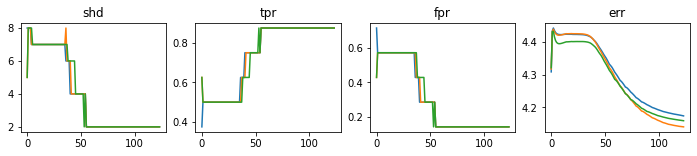

In [14]:
plot_trials(dagtrainer, Validator.params, 'eval')

###### Plot evolution of losses and learning rate

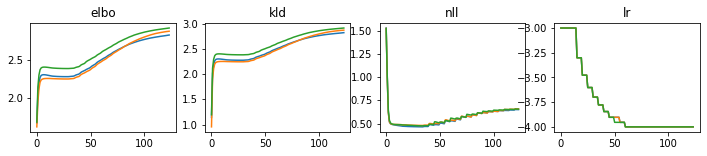

In [15]:
plot_trials(dagtrainer, ELBOLoss.params+OptimModule.params)

###### Plot evolution of Lagrangian parameters and acyclicity 

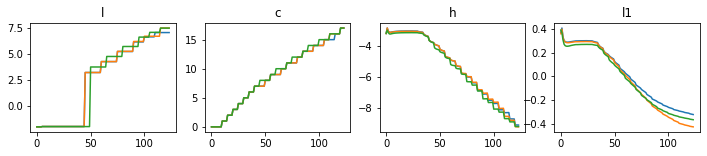

In [16]:
plot_trials(dagtrainer, Coefficients.params+InteractionLoss.params)

###### Plot generated graph adjacency matrices

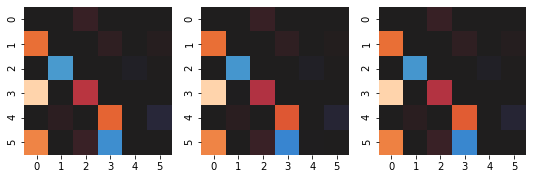

In [17]:
plot_graphs(dagtrainer)

# (2) - SEM Learning

In [18]:
from spacetime.models import SEMCAE
from spacetime.losses import InfoLoss
from spacetime.optimizers import OptimModule, OptimGen
from spacetime.trainers import SEMTrainer
from spacetime.utils import ModelStore, plot_trials

###### Define binary adjacency matrix

In [19]:
st_binary = SpaceTime(st_truth.binary())

###### Define the parameters for the SEM-learning model

In [20]:
gen_params = Parameters(coders = {'n_in':d_data, 'n_hid':8, 'n_out':d_data, 'dropout':0.0, 'gain':1.0},
                        samplers = {'n_in':d_data*n_nodes, 'n_hid':128, 'n_out':2*d_data, 'dropout':0.0, 'gain':1.0},
                        train = {'batch_size':200, 'epochs':80},
                        opts = {'lr_init':3e-3, 'warmups':0},
                        n_nodes = n_nodes)

###### Run one trial of the CAE algorithm

In [21]:
semtrainer = SEMTrainer(n_nodes, X, gen_params, chain=chain)

for idx in range(1):
    semtrainer.train(model=SEMCAE(st_binary, gen_params, latent=latent), print_every=10)

***Epoch: 10/80
   elbo: 10^0.012 || mmd: 10^0.006 || nll: 10^-1.839 || lr: 10^-2.523
***Epoch: 20/80
   elbo: 10^-0.150 || mmd: 10^-0.155 || nll: 10^-2.066 || lr: 10^-2.523
***Epoch: 30/80
   elbo: 10^-0.276 || mmd: 10^-0.285 || nll: 10^-1.924 || lr: 10^-2.523
***Epoch: 40/80
   elbo: 10^-0.476 || mmd: 10^-0.485 || nll: 10^-2.177 || lr: 10^-2.523
***Epoch: 50/80
   elbo: 10^-0.638 || mmd: 10^-0.645 || nll: 10^-2.445 || lr: 10^-2.523
***Epoch: 60/80
   elbo: 10^-0.819 || mmd: 10^-0.833 || nll: 10^-2.317 || lr: 10^-2.523
***Epoch: 70/80
   elbo: 10^-1.024 || mmd: 10^-1.036 || nll: 10^-2.584 || lr: 10^-2.523
***Epoch: 80/80
   elbo: 10^-1.121 || mmd: 10^-1.134 || nll: 10^-2.661 || lr: 10^-2.523

Model finished in 412.7822835445404 seconds
---------------------------------------------------------------------------


###### Plot evolution of losses and learning rate

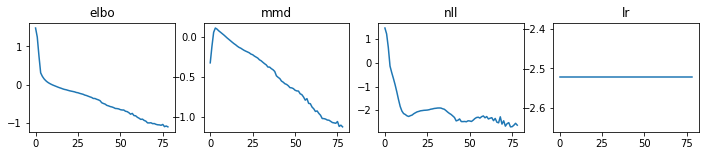

In [22]:
plot_trials(semtrainer, InfoLoss.params+OptimModule.params)

# (3) - SEM performance metrics

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from spacetime.sampler import SCalculator

###### Select model for performance evaluation

In [24]:
caemodel = semtrainer.models[0].model

###### Compare latent probability distribution (Z) with the one made from generative sampling (ZZ)

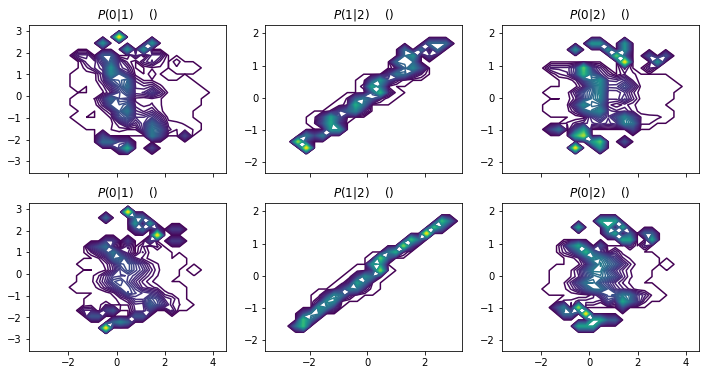

In [25]:
Z = NodeData(caemodel.encode(X.torch()).detach().numpy(), sigma=6)
ZZ = NodeData(caemodel.causal(Z.torch(), mutilate).detach().numpy(), sigma=6)

pZ = PDFVisualizer(caemodel.mask, Z, observables=(0,1,2,3))
pZZ = PDFVisualizer(caemodel.mask, ZZ, observables=(0,1,2,3))

plot_conditionals(col_plot_dict, [pZ, pZZ], ['']*2)

###### Compare data probability distribution (X) with the reconstructed data (XX) and the one made from generative sampling (XXX)

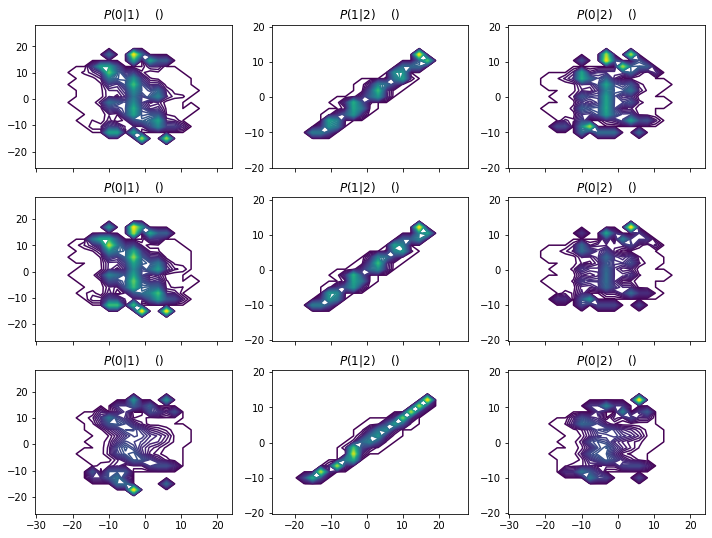

In [26]:
XX = NodeData(caemodel.decode(Z.torch()).detach().numpy(), bins=X.edges())
XXX = NodeData(caemodel.decode(ZZ.torch()).detach().numpy(), bins=X.edges())

pX = PDFVisualizer(caemodel.mask, X, observables=(0,1,2,3))
pXX = PDFVisualizer(caemodel.mask, XX, observables=(0,1,2,3))
pXXX = PDFVisualizer(caemodel.mask, XXX, observables=(0,1,2,3))

plot_conditionals(col_plot_dict, [pX, pXX, pXXX], ['']*3)

###### Generate the probability distributions predicted for an intervention on node 2

In [27]:
x_intv = X.torch()
x_intv[:,2,:] = torch.Tensor(np.random.normal(0, scale=4.0, size=8000)).unsqueeze(-1)

z_intv = Z.torch()
z_intv[:,2,:] = caemodel.encode(x_intv)[:,2,:]
z_intv[:,1,:] = caemodel.causal(z_intv, mutilate)[:,1,:]
z_intv[:,0,:] = caemodel.causal(z_intv, mutilate)[:,0,:]

X_intv = NodeData(x_intv.detach().numpy(), bins=X.edges())
Z_intv = NodeData(z_intv.detach().numpy(), bins=Z.edges())
XX_intv = NodeData(caemodel.decode(z_intv).detach().numpy(), bins=X.edges())

pX_intv = PDFVisualizer(caemodel.mask, X_intv, observables=(0,1,2,3))
pZ_intv = PDFVisualizer(caemodel.mask, Z_intv, observables=(0,1,2,3))
pXX_intv = PDFVisualizer(caemodel.mask, XX_intv, observables=(0,1,2,3))

###### Generate the probability distributions for the ground truth data generated by explicit graph mutilation

In [28]:
z_mutil = caemodel.encode(X_mutil.torch())
Z_mutil = NodeData(z_mutil.sum(dim=-1, keepdims=True).detach().numpy(), sigma=6)
pX_mutil = PDFVisualizer(caemodel.mask, X_mutil, observables=(0,1,2,3))
pZ_mutil = PDFVisualizer(caemodel.mask, Z_mutil, observables=(0,1,2,3))

###### Compare the conditional probability distributions for the predicted intervention (pXX_intv) with the ground truth mutilation (pX_mutil)

Fit conditional KDE for 0 wrt (1,) in 0.0005366802215576172 seconds
Fit conditional KDE for 0 wrt (1,) in 0.0004036426544189453 seconds
Fit conditional KDE for 0 wrt (1,) in 0.0004134178161621094 seconds
Fit conditional KDE for 1 wrt (2,) in 0.00039458274841308594 seconds
Fit conditional KDE for 1 wrt (2,) in 0.0004131793975830078 seconds
Fit conditional KDE for 1 wrt (2,) in 0.00039196014404296875 seconds
Fit conditional KDE for 0 wrt (2,) in 0.0003876686096191406 seconds
Fit conditional KDE for 0 wrt (2,) in 0.00039696693420410156 seconds
Fit conditional KDE for 0 wrt (2,) in 0.00037789344787597656 seconds


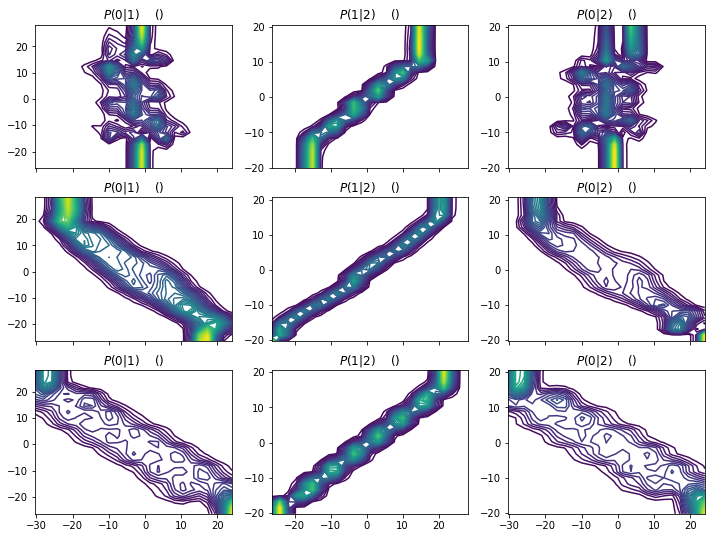

In [29]:
plot_conditionals(col_plot_dict, [pXX, pXX_intv, pX_mutil], ['']*3, smooth=True)

###### Compare the KL Divergence between pXX_intv and pX_mutil at various standard deviations

Fit conditional KDE for 0 wrt (1,) in 0.0005276203155517578 seconds
Fit conditional KDE for 0 wrt (1,) in 0.0007033348083496094 seconds
Fit conditional KDE for 0 wrt (1,) in 0.0005393028259277344 seconds
Fit conditional KDE for 0 wrt (1,) in 0.0003707408905029297 seconds
Fit conditional KDE for 0 wrt (2,) in 0.0004146099090576172 seconds
Fit conditional KDE for 0 wrt (2,) in 0.0003788471221923828 seconds
Fit conditional KDE for 0 wrt (2,) in 0.00047326087951660156 seconds
Fit conditional KDE for 0 wrt (2,) in 0.0003559589385986328 seconds
Fit conditional KDE for 1 wrt (2,) in 0.0004639625549316406 seconds
Fit conditional KDE for 1 wrt (2,) in 0.0003561973571777344 seconds
Fit conditional KDE for 1 wrt (2,) in 0.00037479400634765625 seconds
Fit conditional KDE for 1 wrt (2,) in 0.0003421306610107422 seconds


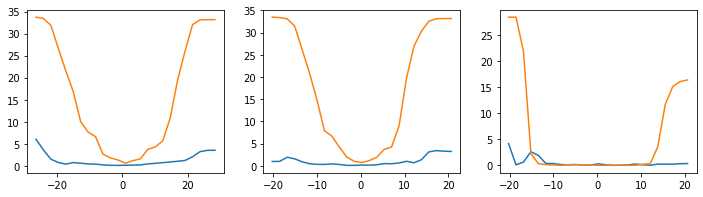

In [30]:
S_Xmutil_XXintv = SCalculator(X_mutil, XX_intv, observables=(0,1,2,3))
S_Xmutil_X = SCalculator(X_mutil, X, observables=(0,1,2,3))

fig, axs = plt.subplots(1, 3, figsize=(12,3))

axs[0].plot(*S_Xmutil_XXintv.compute_S(0,1))
axs[0].plot(*S_Xmutil_X.compute_S(0,1))
axs[1].plot(*S_Xmutil_XXintv.compute_S(0,2))
axs[1].plot(*S_Xmutil_X.compute_S(0,2))
axs[2].plot(*S_Xmutil_XXintv.compute_S(1,2))
axs[2].plot(*S_Xmutil_X.compute_S(1,2))
pass;